# Comparing a conventional and approximate Single-Output GP

In [1]:
import math
import time

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


## Set up some very simple training data

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}
$$
With training and test examples regularly spaced points in [0,1]

In [2]:
nb_training_points = 10000
nb_test_points = 10

train_x = torch.linspace(0, 1, nb_training_points, device=device)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04)

# train_x = torch.linspace(0, 1, nb_training_points, device=device)
# train_y = train_x.pow(2)

## Setting up the models
Both **GP Models** `gpytorch.models.ExactGP` with:
- **Likelihood** `gpytorch.likelihoods.GaussianLikelihood`
- **Zero Mean** `gpytorch.means.ZeroMean` for simplicity

One model witch conventional kernel:
- **RBF Kernel** `gpytorch.kernels.RBFKernel`

One model with approximate kernel:
- **Approximate RBF Kernel** `famgpytorch.kernels.RBFKernelApprox`

In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


## Training the model

In [4]:
conv_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
conv_model.to(device)

approx_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.to(device)
#---------------------------------------------------------------------

# set model in training mode
conv_model.train()
approx_model.train()
conv_likelihood.train()
approx_likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.01)
approx_optimizer = torch.optim.Adam(approx_model.parameters(), lr=0.01)

# "Loss" for GPs - marginal log likelihood
conv_mll = gpytorch.mlls.ExactMarginalLogLikelihood(conv_likelihood, conv_model)
approx_mll = gpytorch.mlls.ExactMarginalLogLikelihood(approx_likelihood, approx_model)

start = time.perf_counter()
conv_loss = None
for i in range(50):
    conv_optimizer.zero_grad()
    conv_output = conv_model(train_x)
    conv_loss = -conv_mll(conv_output, train_y)
    conv_loss.backward()
    conv_optimizer.step()

print(
    f'Conventional:   Time: {time.perf_counter() - start:.3f} seconds   '
    f'Loss: {conv_loss.item():.3f}   '
    f'lengthscale: {conv_model.covar_module.lengthscale.item():.3f}   '
    f'noise: {conv_model.likelihood.noise.item():.3f}'
)

start = time.perf_counter()
approx_loss = None
for i in range(50):
    approx_optimizer.zero_grad()
    approx_output = approx_model(train_x)
    approx_loss = -approx_mll(approx_output, train_y)
    approx_loss.backward()
    approx_optimizer.step()

print(
    f'Approximate:    Time: {time.perf_counter() - start:.3f} seconds   '
    f'Loss: {approx_loss.item():.3f}   '
    f'lengthscale: {approx_model.covar_module.lengthscale.item():.3f}   '
    f'noise: {approx_model.likelihood.noise.item():.3f}   '
    f'alpha: {approx_model.covar_module.alpha.item():.3f}'
)

C:\Users\pasca\Documents\Studienarbeit\PythonProject\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Conventional:   Time: 738.991 seconds   Loss: 0.591   lengthscale: 0.506   noise: 0.472


KeyboardInterrupt: 

## Resulting covariance matrix


RMSE: tensor(5.4887e-05, device='cuda:0')


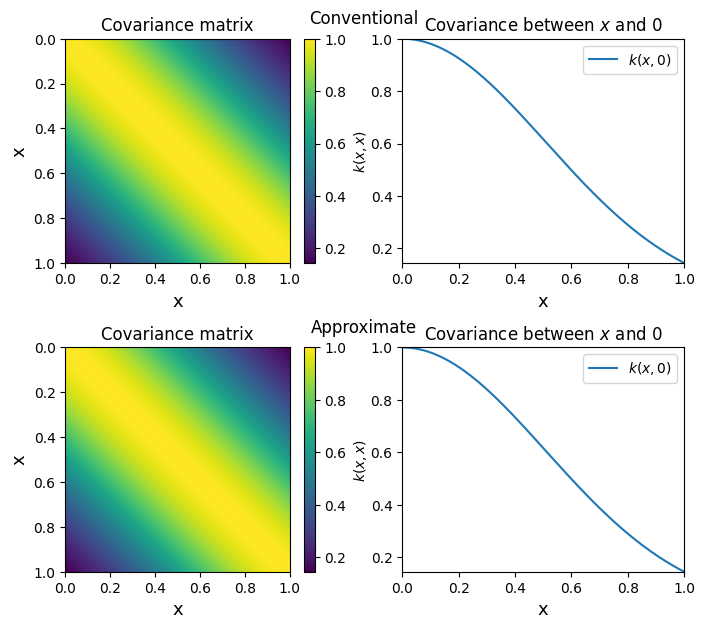

In [5]:
with torch.no_grad():
    conv_f_train = conv_model(train_x)
    conv_train_covar = conv_f_train.covariance_matrix

    approx_f_train = approx_model(train_x)
    approx_train_covar = approx_f_train.covariance_matrix

    rmse = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar)**2))
    print("\nRMSE:", rmse)

    # plot resulting covariance matrix
    fig = plt.figure(figsize=(8, 6))
    subfigs = fig.subfigures(2, 1, hspace=0.06)
    subfigs[0].suptitle("Conventional")
    subfigs[1].suptitle("Approximate")
    vmin = torch.min(torch.cat((conv_train_covar, approx_train_covar))).item()
    vmax = torch.max(torch.cat((conv_train_covar, approx_train_covar))).item()
    for row, covar in enumerate([conv_train_covar.to('cpu'), approx_train_covar.to('cpu')]):
        ax1, ax2 = subfigs[row].subplots(1, 2)

        im = ax1.imshow(covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im, ax=ax1)
        cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
        ax1.set_title("Covariance matrix")
        ax1.set_xlabel('x', fontsize=13)
        ax1.set_ylabel('x', fontsize=13)
        ax1.set_xticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_yticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_xticklabels(np.round(np.linspace(0, 1, min(nb_training_points, 6)), 2))
        ax1.set_yticklabels(np.round(np.linspace(0, 1, min(nb_training_points, 6)), 2))
        ax1.grid(False)

        ax2.plot(train_x.to('cpu').numpy(), covar.numpy()[:,0], label='$k(x,0)$')
        ax2.set_xlabel('x', fontsize=13)
        ax2.set_title('Covariance between $x$ and $0$')
        ax2.set_xlim([0, 1])
        ax2.set_ylim([vmin, 1])
        ax2.legend(loc=1)

## Make predictions with the models

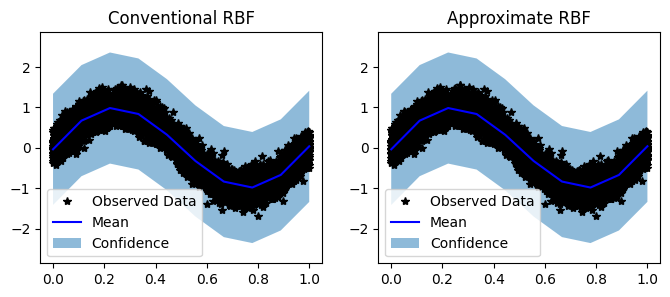

In [6]:
# set model to evaluation mode (predictive posterior)
conv_model.eval()
approx_model.eval()
conv_likelihood.eval()
approx_likelihood.eval()

# make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, nb_test_points, device=device)
    conv_observed_pred = conv_likelihood(conv_model(test_x))
    approx_observed_pred = approx_likelihood(approx_model(test_x))

    conv_mean = conv_observed_pred.mean
    approx_mean = approx_observed_pred.mean

    conv_lower, conv_upper = conv_observed_pred.confidence_region()
    approx_lower, approx_upper = approx_observed_pred.confidence_region()

    if device != 'cpu':
        # pull tensors into cpu for plotting
        train_x = train_x.to('cpu')
        train_y = train_y.to('cpu')
        test_x = test_x.to('cpu')
        conv_mean = conv_mean.to('cpu')
        approx_mean = approx_mean.to('cpu')
        conv_lower = conv_lower.to('cpu')
        conv_upper = conv_upper.to('cpu')
        approx_lower = approx_lower.to('cpu')
        approx_upper = approx_upper.to('cpu')

    # plot model fit
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # -- Conventional
    # plot training data as black stars
    ax1.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # plot predictive means as blue line
    ax1.plot(test_x.numpy(), conv_mean.numpy(), 'b')
    # shade between lower and upper confidence bounds
    ax1.fill_between(test_x.numpy(), conv_lower.numpy(), conv_upper.numpy(), alpha=0.5)
    ax1.set_ylim([
        np.min([conv_lower.numpy(), approx_lower.numpy()])-0.5,
        np.max([conv_upper.numpy(), approx_upper.numpy()])+0.5
    ])

    ax1.legend(['Observed Data', 'Mean', 'Confidence'])
    ax1.set_title('Conventional RBF')

    # -- Approximate
    # plot training data as black stars
    ax2.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # plot predictive means as blue line
    ax2.plot(test_x.numpy(), approx_mean.numpy(), 'b')
    # shade between lower and upper confidence bounds
    ax2.fill_between(test_x.numpy(), approx_lower.numpy(), approx_upper.numpy(), alpha=0.5)
    ax2.set_ylim([
        np.min([conv_lower.numpy(), approx_lower.numpy()])-0.5,
        np.max([conv_upper.numpy(), approx_upper.numpy()])+0.5
    ])

    ax2.legend(['Observed Data', 'Mean', 'Confidence'])
    ax2.set_title('Approximate RBF')